#### Import Libraries

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.io import wavfile
import seaborn as sns
from scipy.spatial import distance

import scipy.stats
import os
os.getcwd()

'/Volumes/GoogleDrive/My Drive/1 Research/1 Gerbil Vocalization/pyroomacoustics/muse-python/scripts'

In [2]:
cd ..

/Volumes/GoogleDrive/My Drive/1 Research/1 Gerbil Vocalization/pyroomacoustics/muse-python


In [3]:
import pyroomacoustics as pra
from pyroomacoustics.directivities import CardioidFamily, DirectionVector, DirectivityPattern

Beamforming reference: https://pyroomacoustics.readthedocs.io/en/pypi-release/pyroomacoustics.beamforming.html?highlight=beamforming

Parameters:
- R (numpy.ndarray) – Mics positions
- fs (int) – Sampling frequency
- N (int, optional) – Length of FFT, i.e. number of FD beamforming weights, equally spaced. Defaults to 1024.
- Lg (int, optional) – Length of time-domain filters. Default to N.
- hop (int, optional) – Hop length for frequency domain processing. Default to N/2.
- zpf (int, optional) – Front zero padding length for frequency domain processing. Default is 0.
- zpb (int, optional) – Zero padding length for frequency domain processing. Default is 0.

### Load Audio File

In [7]:
stim_dir = '../muse-python/stimuli/tones/sine_2khz.wav'
stim_name = stim_dir.split('/')[-1]
fs, signal = wavfile.read(os.path.abspath(stim_dir))

### Create a room

In [8]:
x_dim, y_dim, z_dim = 1.83, 2.44, 0.76 # room 2

In [9]:
ceiling_floor = "curtains_fabric_folded"
wall_material = "curtains_fabric_folded"

In [76]:
materials = pra.make_materials(
    ceiling = ceiling_floor,
    floor   = ceiling_floor,
    east    = wall_material,
    west    = wall_material,
    north   = wall_material,
    south   = wall_material
)

room = pra.ShoeBox(
    [x_dim, y_dim],
    fs=fs,
    materials=materials,
    max_order=9  # Maximum number of times a sound wave can reflect (?)
) 


In [77]:
room.fs

192000

### Define Speaker Position & Add Speaker

In [78]:
offset = 0.1
x_pos, y_pos = x_dim-offset, y_dim-offset # center of the room
z_pos = 0.01
speaker_pos = (x_pos, y_pos)

In [79]:
room.add_source(speaker_pos, signal=signal, delay=0)

### Define and Add Microphones

In [80]:
Lg_t = 0.100                # filter size in seconds
Lg = np.ceil(Lg_t*fs)       # in samples

In [188]:
# Create geometry equivalent to Amazon Echo
xc, yc = x_dim/2, y_dim/2     # position the microphones at the center of the room
center = [xc, yc, 0.1]; radius = 37.5e-3
fft_len = 512
echo = pra.circular_2D_array(center=center[:2], M=6, phi0=0, radius=radius)
echo = np.concatenate((echo, np.array(center[:2], ndmin=2).T), axis=1)
# echo = np.concatenate((echo, np.ones((1, echo.shape[1])) * center[2]), axis=0)
mics = pra.Beamformer(echo, room.fs, N=fft_len, Lg=Lg)


In [82]:
room.add_microphone_array(mics)

In [186]:
# plt.plot(echo.T[:,0], echo.T[:,1], 'o')

In [187]:
# Compute DAS weights
mics.rake_delay_and_sum_weights(room.sources[0][:1])

### plot the room and resulting beamformer before simulation


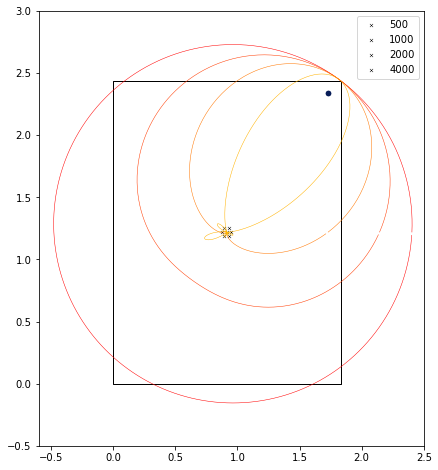

In [87]:
# plot the room and resulting beamformer before simulation
fig, ax = room.plot(freq=[500, 1000, 2000, 4000], img_order=0)
ax.legend(['500', '1000', '2000', '4000'])
ax.set_xlim([-0.6,2.5])
ax.set_ylim([-.5,3])
fig.set_size_inches(20, 8)

### Simulate the propagation

In [91]:
room.compute_rir()
room.simulate()

Delay-and-sum (DAS) beamforming

In [92]:
signal_das = mics.process(FD=False)

### Direction of Arrival (DOA) Estimation

In [94]:
c = 343.    # speed of sound
fs = 16000  # sampling frequency
nfft = 256  # FFT size
freq_range = [300, 3500]

Short-Time Fourier Transform (STFT) input

In [95]:
X = pra.transform.stft.analysis(room.mic_array.signals.T, nfft, nfft // 2)
X = X.transpose([2, 1, 0])

### DOA with multiple algorithms

In [225]:
algo_names = ['SRP', 'FRIDA', 'TOPS', 'MUSIC']
spatial_resp = dict()

# loop through algos
for algo_name in algo_names:
    # Construct the new DOA object
    # the max_four parameter is necessary for FRIDA only
    doa = pra.doa.algorithms[algo_name](echo, fs, nfft, c=c, num_src=1, max_four=4)

    # this call here perform localization on the frames in X
    doa.locate_sources(X, freq_range=freq_range)
    
    # store spatial response
    if algo_name is 'FRIDA':
        spatial_resp[algo_name] = np.abs(doa._gen_dirty_img())
    else:
        spatial_resp[algo_name] = doa.grid.values
        
    # normalize   
    min_val = spatial_resp[algo_name].min()
    max_val = spatial_resp[algo_name].max()
    spatial_resp[algo_name] = (spatial_resp[algo_name] - min_val) / (max_val - min_val)


<>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
/var/folders/vb/wpflndf94mggppllgf5dpcfh0000gn/T/ipykernel_70063/1238517307.py:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if algo_name is 'FRIDA':
/Users/akihiro/opt/anaconda3/envs/spyder/lib/python3.9/site-packages/pyroomacoustics/doa/tools_fri_doa_plane.py:925: LinAlgWarning: Ill-conditioned matrix (rcond=5.91519e-35): result may not be accurate.
  c_ri_half = linalg.solve(mtx_loop, rhs, check_finite=False)[:sz_coef]
/Users/akihiro/opt/anaconda3/envs/spyder/lib/python3.9/site-packages/pyroomacoustics/doa/tools_fri_doa_plane.py:925: LinAlgWarning: Ill-conditioned matrix (rcond=4.37861e-35): result may not be accurate.
  c_ri_half = linalg.solve(mtx_loop, rhs, check_finite=False)[:sz_coef]
/Users/akihiro/opt/anaconda3/envs/spyder/lib/python3.9/site-packages/pyroomacoustics/doa/tools_fri_doa_plane.py:925: LinAlgWarning: Ill-conditioned matrix (rco

In [235]:
print(doa.azimuth_recon[0], 'rad -->', doa.azimuth_recon[0] * 180/np.pi ,'deg')

0.9424777960769379 rad --> 54.0 deg


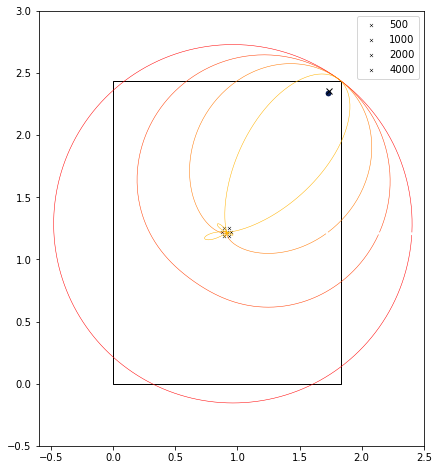

In [228]:
# plot the room and resulting beamformer before simulation
fig, ax = room.plot(freq=[500, 1000, 2000, 4000], img_order=0)
ax.legend(['500', '1000', '2000', '4000'])
ax.set_xlim([-0.6,2.5])
ax.set_ylim([-.5,3])
fig.set_size_inches(20, 8)

ax.plot(1.4*np.cos(doa.azimuth_recon[0])+x_dim/2, 1.4*np.sin(doa.azimuth_recon[0])+y_dim/2, 'x', color='k')

plt.show()

In [229]:
p_x = doa.grid.x[None,None,:]
p_y = doa.grid.y[None,None,:]
r_x = doa.L[0, None, :, None]
r_y = doa.L[1, None, :, None]
dist = (p_x * r_x) + (p_y * r_y)

In [230]:
dist.shape

(1, 7, 360)

/Users/akihiro/opt/anaconda3/envs/spyder/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


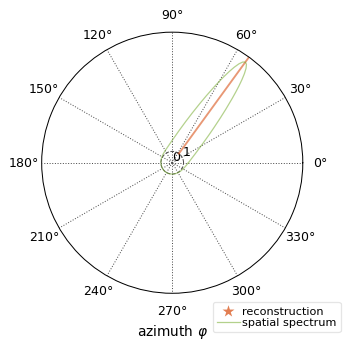

In [231]:
# doa.azimuth_recon
doa.polar_plt_dirac()

### Plot the estimated spatial spectra

/var/folders/vb/wpflndf94mggppllgf5dpcfh0000gn/T/ipykernel_70063/3749770165.py:41: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.xaxis.grid(b=True, color=[0.3, 0.3, 0.3], linestyle=':')
/var/folders/vb/wpflndf94mggppllgf5dpcfh0000gn/T/ipykernel_70063/3749770165.py:42: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.yaxis.grid(b=True, color=[0.3, 0.3, 0.3], linestyle='--')
/var/folders/vb/wpflndf94mggppllgf5dpcfh0000gn/T/ipykernel_70063/3749770165.py:41: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.xaxis.grid(b=True, color=[0.3, 0.3, 0.3], linestyle=':')
/var/folders/vb/wpflndf94mggppllgf5dpcfh00

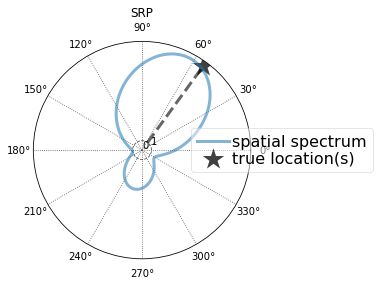

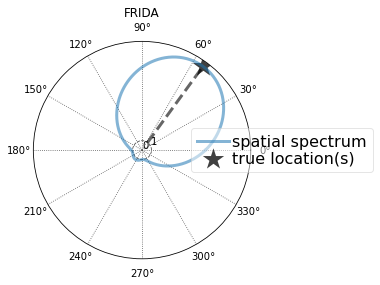

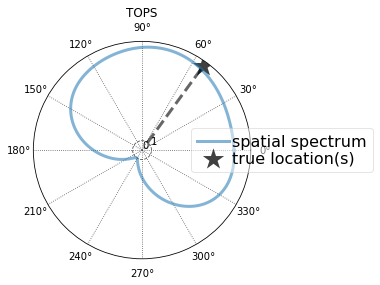

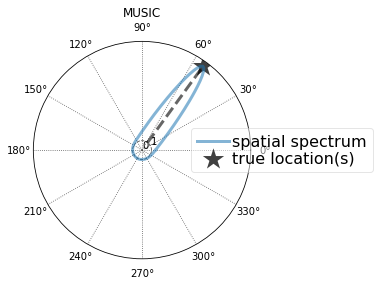

In [232]:
azimuth = np.ones(1)*np.arctan((y_pos-yc)/(x_pos-xc)) # True location

# plotting param
base = 1.
height = 10.
true_col = [0, 0, 0]

# loop through algos
phi_plt = doa.grid.azimuth
for algo_name in algo_names:
    # plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='polar')
    c_phi_plt = np.r_[phi_plt, phi_plt[0]]
    c_dirty_img = np.r_[spatial_resp[algo_name], spatial_resp[algo_name][0]]
    ax.plot(c_phi_plt, base + height * c_dirty_img, linewidth=3,
            alpha=0.55, linestyle='-',
            label="spatial spectrum")
    plt.title(algo_name)
    
    # plot true loc
    for angle in azimuth:
        ax.plot([angle, angle], [base, base + height], linewidth=3, linestyle='--',
            color=true_col, alpha=0.6)
    K = len(azimuth)
    ax.scatter(azimuth, base + height*np.ones(K), c=np.tile(true_col,
               (K, 1)), s=500, alpha=0.75, marker='*',
               linewidths=0,
               label='true location(s)')

    plt.legend()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, framealpha=0.5,
              scatterpoints=1, loc='center right', fontsize=16,
              ncol=1, bbox_to_anchor=(1.6, 0.5),
              handletextpad=.2, columnspacing=1.7, labelspacing=0.1)

    ax.set_xticks(np.linspace(0, 2 * np.pi, num=12, endpoint=False))
    ax.xaxis.set_label_coords(0.5, -0.11)
    ax.set_yticks(np.linspace(0, 1, 2))
    ax.xaxis.grid(b=True, color=[0.3, 0.3, 0.3], linestyle=':')
    ax.yaxis.grid(b=True, color=[0.3, 0.3, 0.3], linestyle='--')
    ax.set_ylim([0, 1.05 * (base + height)])
    
plt.show()
